# Result Analysis
This notebook analyzes experimental results for different algorithmic variants on small and large instances, including multi-deadline scenarios.

## Imports and Plot Settings

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from scipy.stats import sem
import warnings
import matplotlib as mpl

warnings.filterwarnings("ignore")

mpl.rcParams.update({
    'font.size': 13,
    'axes.titlesize': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
    'figure.titlesize': 13
})


## Configuration

In [13]:
method_markers = {
    'GCP': 'o',
    'Greedy': 'D',
    'ACO': '^',
    'ILP': 'v',
    'Genetic': 'X',
}

# Helper Functions

These functions handle reading result CSVs, extracting method labels, computing error bars, and preparing formatted data for plotting.


In [20]:
def get_csv_files(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

def read_and_aggregate(folder_path):
    all_dfs = []
    for filepath in get_csv_files(folder_path):
        try:
            df = pd.read_csv(filepath)
            df["DatasetName"] = os.path.basename(df["Dataset"].iloc[0])
            all_dfs.append(df)
        except Exception as e:
            print(f"Error reading {filepath}: {e}")
    return pd.concat(all_dfs, ignore_index=True)

def read_and_aggregate2(folder_path1, folder_path2):
    files1 = get_csv_files(folder_path1)
    files2 = get_csv_files(folder_path2)
    all_dfs = []
    for filepath1, filepath2 in zip(files1, files2):
        try:
            df1 = pd.read_csv(filepath1)
            df1 = df1[df1["Method"] == "Gurobi"]
            df2 = pd.read_csv(filepath2)
            df2 = df2[df2["Method"] != "Gurobi"]
            df = pd.concat([df1, df2], ignore_index=True)
            df["DatasetName"] = os.path.basename(df["Dataset"].iloc[0])
            all_dfs.append(df)
        except Exception as e:
            print(f"Error reading {filepath1} or {filepath2}: {e}")
    return pd.concat(all_dfs, ignore_index=True)


## Small Instance Analysis
This section reproduces plots for small instance datasets with and without ILP baseline.

In [21]:
method_display_names = {
    'Hoogeveen': 'GCP',
    'Greedy': 'Greedy',
    'Gurobi': 'ILP',
    'Genetic': 'Genetic',
}
selected_methods = list(method_display_names.keys())

df_all = read_and_aggregate2("small_gurobi", "small_100_80")
df_filtered = df_all[df_all['Method'].isin(selected_methods)].copy()
df_filtered["DisplayMethod"] = df_filtered["Method"].map(method_display_names)

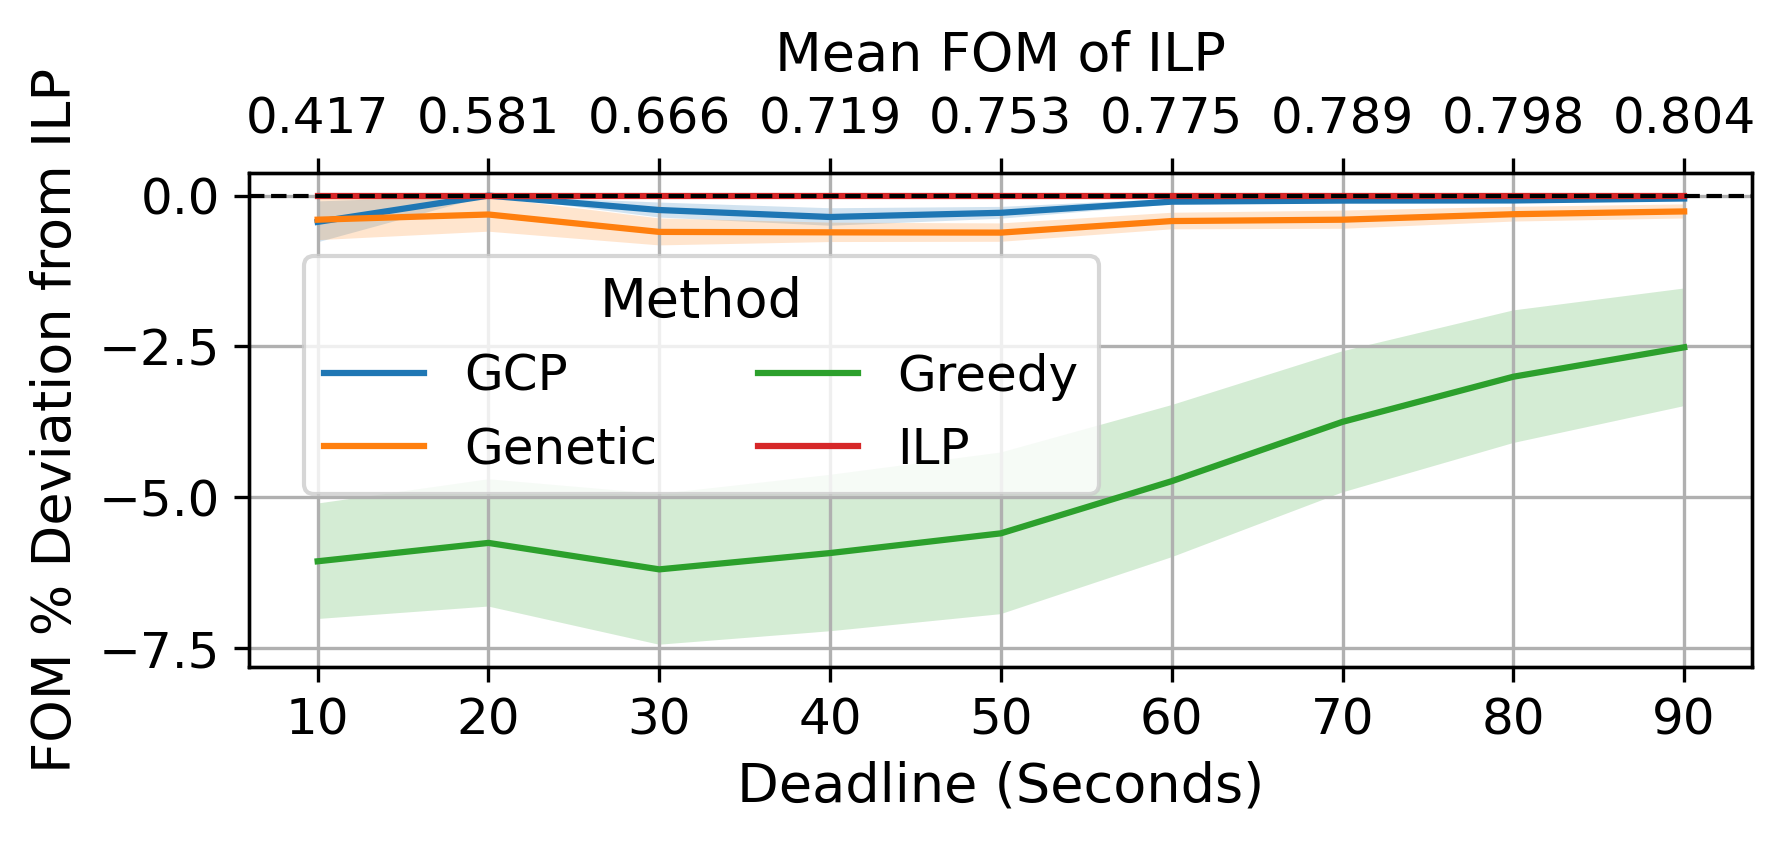

In [22]:
agg = df_filtered.groupby(['DisplayMethod', 'Budget'])['SumProb'].agg(['mean', sem]).reset_index()
baseline = df_filtered[df_filtered['DisplayMethod'] == 'ILP'][['DatasetName', 'Budget', 'SumProb']]
baseline = baseline.rename(columns={'SumProb': 'BaselineFOM'})

df_dev = pd.merge(df_filtered, baseline, on=['DatasetName', 'Budget'])
df_dev['FOMDeviation'] = df_dev['SumProb'] - df_dev['BaselineFOM']

df_dev['FOMPctDeviation'] = 100 * (df_dev['SumProb'] - df_dev['BaselineFOM']) / df_dev['BaselineFOM']
agg_pct_dev = df_dev.groupby(['DisplayMethod', 'Budget'])['FOMPctDeviation'].agg(['mean', sem]).reset_index()
agg_gcp = df_dev[df_dev['DisplayMethod'] == 'ILP'].groupby('Budget')['BaselineFOM'].mean().reset_index()

fig, ax1 = plt.subplots(figsize=(6, 3), dpi=300)
#  % deviation with error bars
for method in agg_pct_dev['DisplayMethod'].unique():
    sub = agg_pct_dev[agg_pct_dev['DisplayMethod'] == method]
    ax1.plot(sub['Budget'], sub['mean'], label=method)
    ax1.fill_between(sub['Budget'], sub['mean'] - sub['sem'], sub['mean'] + sub['sem'], alpha=0.2)

ax1.axhline(0, linestyle='--', color='black', linewidth=1)
ax1.set_xlabel("Deadline (Seconds)")
ax1.set_ylabel("FOM % Deviation from ILP")
ax1.set_xticks(sorted(df_dev['Budget'].unique()))
ax1.grid(True)
ax1.legend(title="Method", ncol=2, loc='lower left', bbox_to_anchor=(0.02, 0.3))

# top x-axis showing GCP average FoM
ax2 = ax1.twiny()
ax2.set_xlim(ax1.get_xlim()) 

budgets = agg_gcp['Budget']
avg_foms = agg_gcp['BaselineFOM'].round(3)
ax2.set_xticks(budgets[::1])
ax2.set_xticklabels(avg_foms[::1])
ax2.set_xlabel("Mean FOM of ILP", labelpad=6)

plt.tight_layout()
# plt.savefig("plots/Percentage_Deviation_from_ILP.png", dpi=300)
plt.show()


## Large Instance Analysis

This section corresponds to **Figures 4 and 6** in the paper.

- Evaluates search strategies on **large tile sets** under various deadlines (10s–1200s).
- Includes runtime measurements and FoM performance.


In [23]:
method_display_names = {
    'Hoogeveen': 'GCP',
    'Greedy': 'Greedy',
    'Genetic': 'Genetic',
}
selected_methods = list(method_display_names.keys())

folder_path = "large"
df_all = read_and_aggregate(folder_path)
budgets = [10, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200]
df_all = df_all[df_all['Budget'].isin(budgets)]

df_filtered = df_all[df_all['Method'].isin(selected_methods)].copy()
df_filtered["DisplayMethod"] = df_filtered["Method"].map(method_display_names)

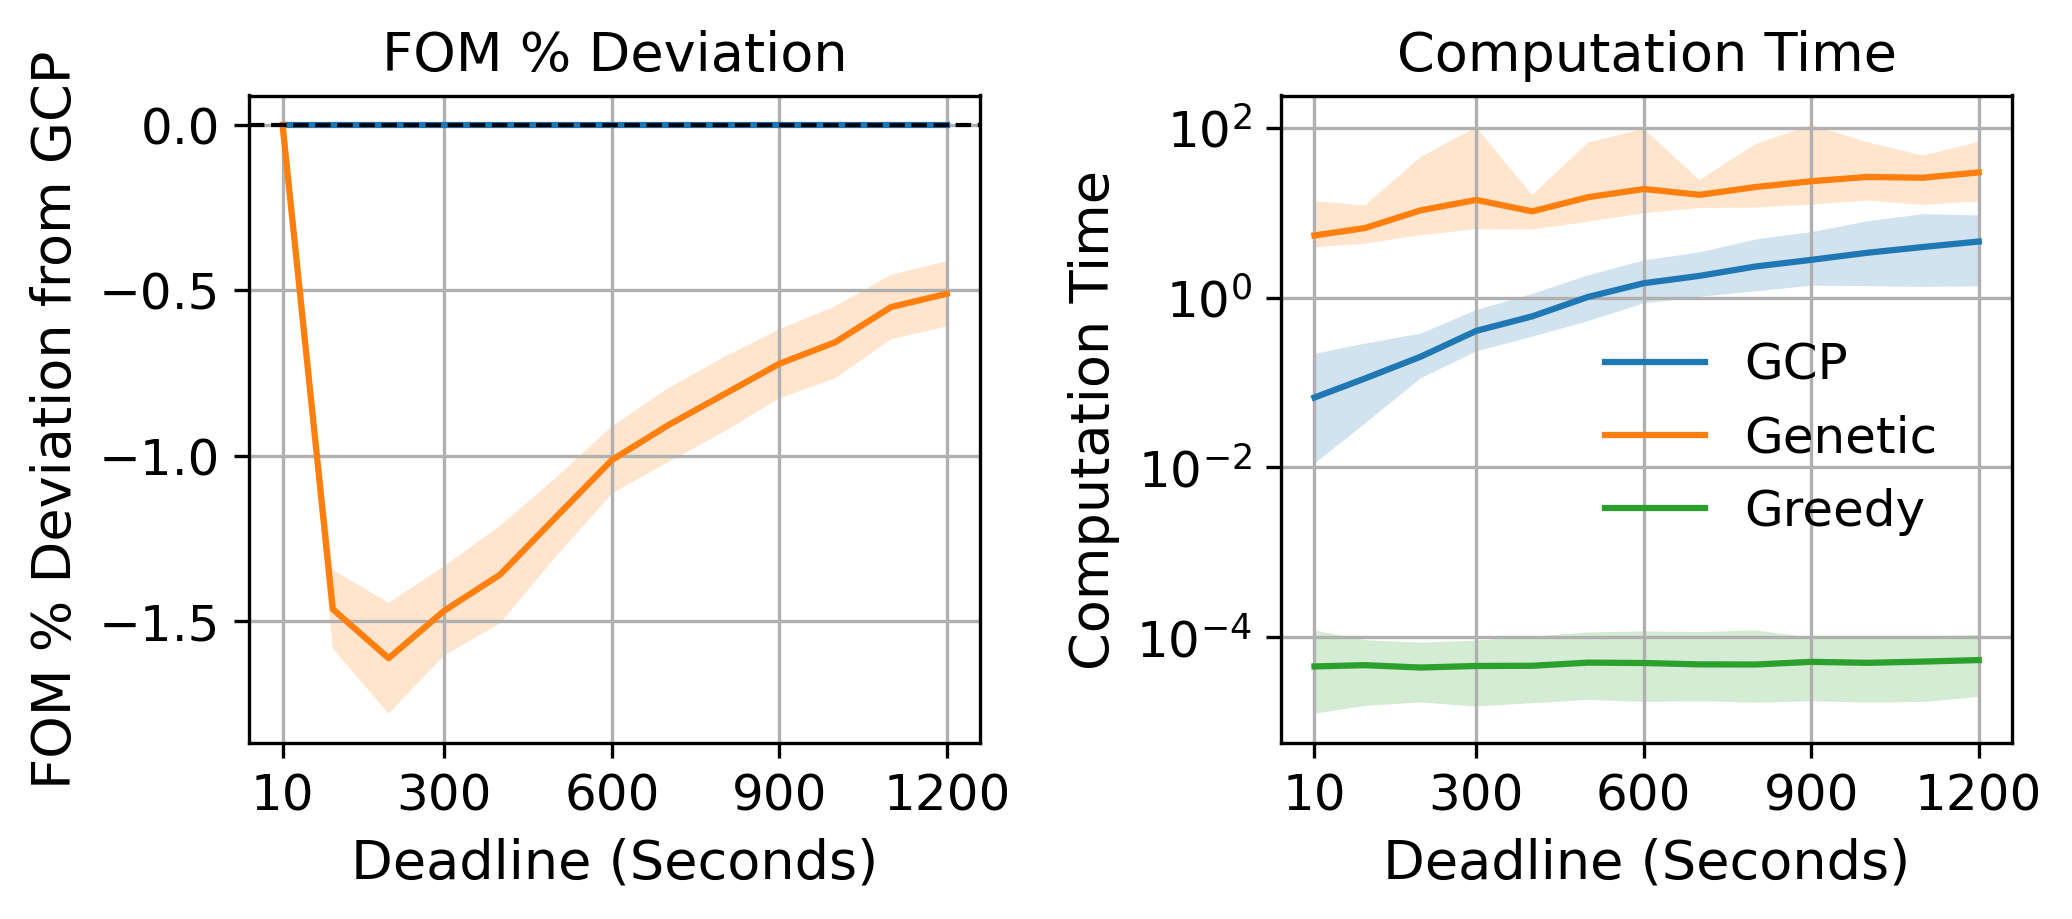

In [26]:
# Baseline for deviation (GCP)
baseline = (
    df_filtered[df_filtered['DisplayMethod'] == 'GCP']
    [['DatasetName', 'Budget', 'SumProb']]
    .rename(columns={'SumProb': 'BaselineFOM'})
)

# Rebuild df_dev for the current dataset (avoid stale state)
df_dev = df_filtered.merge(baseline, on=['DatasetName', 'Budget'], how='inner')
df_dev['FOMPctDeviation'] = 100.0 * (df_dev['SumProb'] - df_dev['BaselineFOM']) / df_dev['BaselineFOM']

# Aggregate for plotting
agg_pct_dev = (
    df_dev.groupby(['DisplayMethod', 'Budget'])['FOMPctDeviation']
    .agg(['mean', sem]).reset_index()
)
agg_time = (
    df_filtered.groupby(['DisplayMethod', 'Budget'])['TimeSec']
    .agg(['mean', 'min', 'max']).reset_index()
)

# X ticks (shared)
x_ticks = sorted(df_filtered['Budget'].unique())

# Make sure ax order matches your titles
fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(7.2, 3.5), dpi=300)

# ---- Left: Computation Time ----
for m in agg_time['DisplayMethod'].unique():
    sub = agg_time[agg_time['DisplayMethod'] == m]
    ax1.plot(sub['Budget'], sub['mean'], label=m)
    ax1.fill_between(sub['Budget'], sub['min'], sub['max'], alpha=0.2)
ax1.set_xlabel("Deadline (Seconds)")
ax1.set_ylabel("Computation Time")
ax1.set_yscale("log")
ax1.set_xticks(x_ticks[::3])
ax1.set_title("Computation Time")
ax1.grid(True)

# ---- Right: % Deviation ----
for m in agg_pct_dev['DisplayMethod'].unique():
    if m == "Greedy":
        continue
    sub = agg_pct_dev[agg_pct_dev['DisplayMethod'] == m]
    ax2.plot(sub['Budget'], sub['mean'], label=m)
    ax2.fill_between(sub['Budget'], sub['mean'] - sub['sem'], sub['mean'] + sub['sem'], alpha=0.2)
ax2.axhline(0, linestyle='--', color='black', linewidth=1)
ax2.set_xlabel("Deadline (Seconds)")
ax2.set_ylabel("FOM % Deviation from GCP")
ax2.set_xticks(x_ticks[::3])
ax2.set_title("FOM % Deviation")
ax2.grid(True)

# Shared legend
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower left", bbox_to_anchor=(0.75, 0.35), ncol=1, frameon=False)

plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

## Average Figure of Merit vs Deadline after accounting for WCET.

In [27]:
folder_path = "subtract_wcrt2"
df_all = read_and_aggregate(folder_path)
df_filtered = df_all[df_all['Method'].isin(selected_methods)].copy()
df_filtered["DisplayMethod"] = df_filtered["Method"].map(method_display_names)

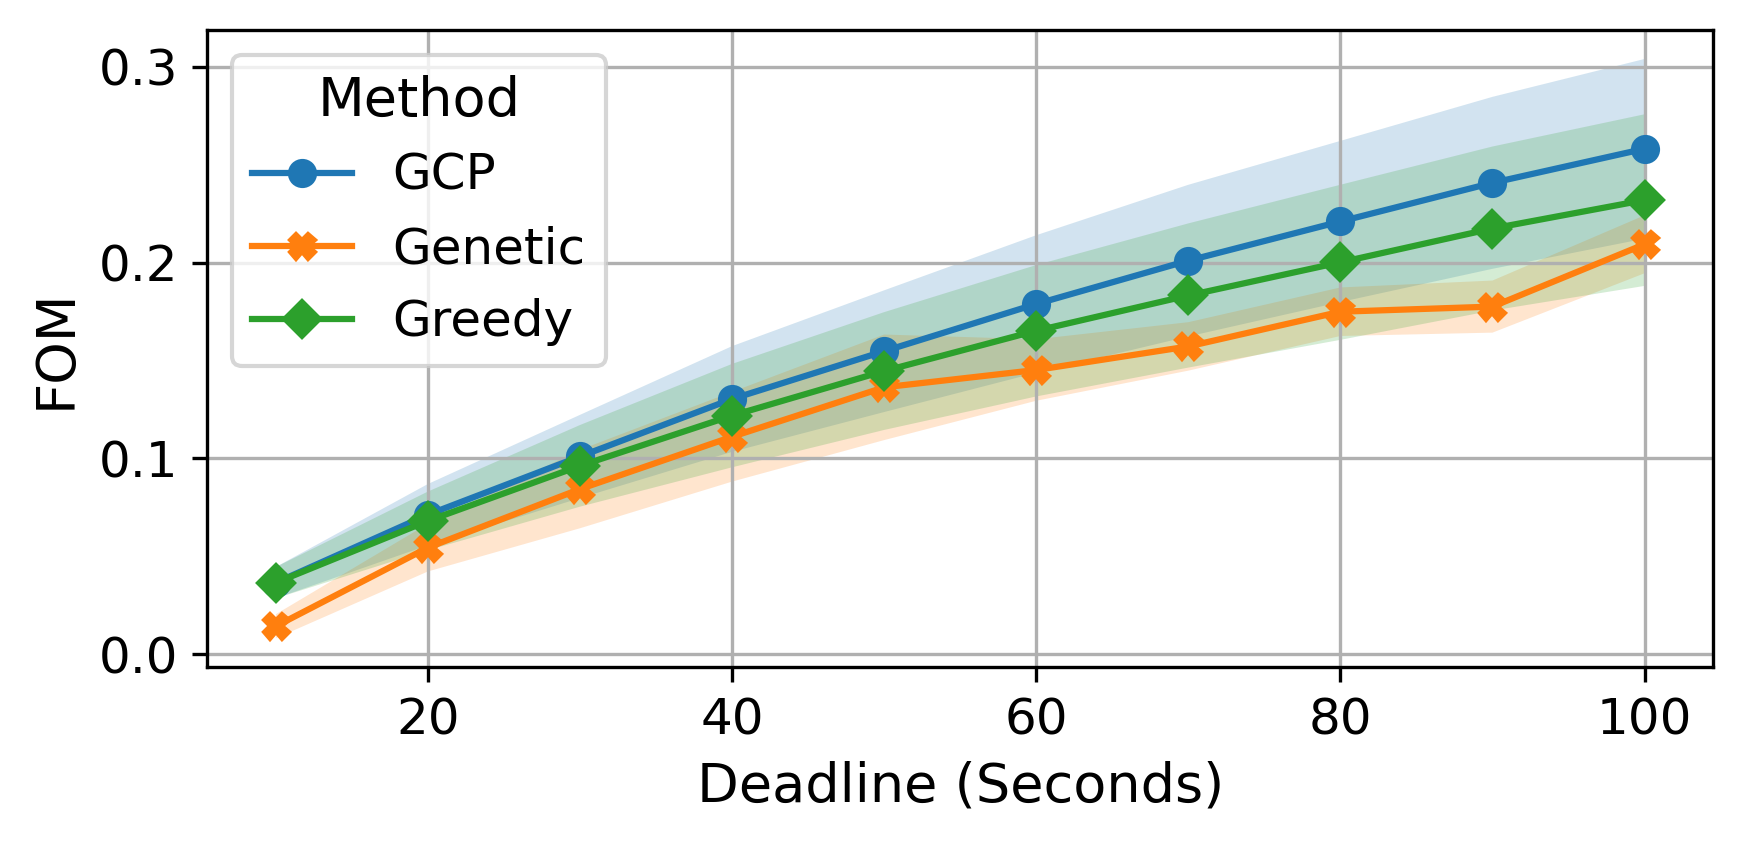

In [28]:
agg = df_filtered.groupby(['DisplayMethod', 'Budget'])['SumProb'].agg(['mean', sem]).reset_index()
plt.figure(figsize=(6, 3), dpi=300)
for method in agg['DisplayMethod'].unique():
    sub = agg[agg['DisplayMethod'] == method]
    marker = method_markers.get(method, 'o')
    plt.plot(sub['Budget'], sub['mean'], label=method, marker=marker)
    plt.fill_between(sub['Budget'], sub['mean'] - sub['sem'], sub['mean'] + sub['sem'], alpha=0.2)
plt.xlabel("Deadline (Seconds)")
plt.ylabel("FOM")
plt.legend(title="Method")
plt.grid(True)
x_ticks = sorted(agg['Budget'].unique())
plt.tight_layout()
# plt.savefig("plots/Average_FOM_vs_Deadline.png", dpi=300)
plt.show()

## ⏱️ Multi-Deadline Scenario Analysis

This section corresponds to **Figures 7 and 8** in the paper.

- Evaluates strategies across **multiple deadlines**, where the search task is divided across segments.
- Each strategy (e.g., `SO1`–`SO5`, `D6`, `D7`) defines how deadlines are distributed among segments.


In [29]:
# Define custom markers for each method
markers = {
    'SO1': 'o',
    'SO2': 's',
    'SO3': 'D',
    'SO4': '^',
    'SO5': 'v',
    'D6': 'X',
    'D7': 'P'
}

base_betas = [1.0, 1.0, 0.5, 0.4, 0.3, 0.2, 0.1, 0.3, 0.2, 0.1, 0.0, 0.0, 0.0]
selected_indices = [1, 2, 5]
labels = ["SO1", "SO2", "SO3", "SO4", "SO5", "D6"]

# Compute segment ranges
ranges = [(0, selected_indices[0])]
for i in range(len(selected_indices) - 1):
    ranges.append((selected_indices[i] + 1, selected_indices[i + 1]))

# Select corresponding beta values
selected_beta = [base_betas[i] for i in selected_indices]


def plotMultiDeadlines(df):
    plt.figure(figsize=(3, 3), dpi=150)
    selected_deadlines = set()
    for idx, label in zip(selected_indices, labels):
        row = df.iloc[idx]
        fom = row["FOMs"]
        # Accumulate FoM over defined ranges
        segment_fom = [sum(fom[a:b+1]) for a, b in ranges]
        # Compute discounted cumulative FoM
        efom = []
        acc = 0.0
        for beta, f in zip(selected_beta, segment_fom):
            # print(beta)
            acc += beta * f
            efom.append(acc)

        # Plot only selected deadlines
        deadlines = row["Budgets"]
        # print(deadlines)
        selected_deadlines = [deadlines[i] for i in selected_indices]
        # print(selected_deadlines)
        # selected_deadlines = [0.0] + selected_deadlines
        # efom = [0.0] + efom

        plt.plot(
            selected_deadlines,
            efom,
            label=label,
            marker=markers.get(label, 'o'),
            linewidth=1.5,
            markersize=6
        )

    # Final touches
    plt.xlabel("Deadlines (Seconds)")
    plt.ylabel("Expected FoM")
    plt.xticks(selected_deadlines)
    plt.legend()
    plt.ylim(bottom=0.03)
    plt.tight_layout()
    # plt.savefig("plots/multi_expected_fom.png", dpi=300)
    plt.show()

1.0
0.5
0.2
1.0
0.5
0.2
1.0
0.5
0.2


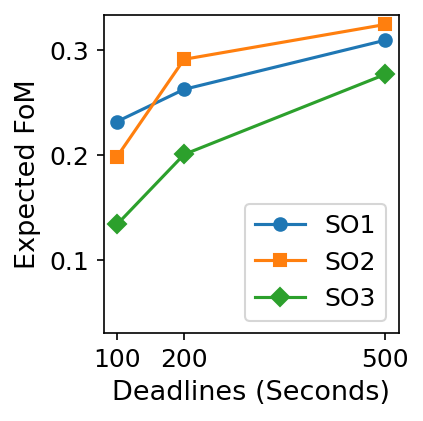

In [30]:

# Load data
path = "multi_deadline"
fname = "GW200216_220804"
filepath = f"{path}/multi_filtered_{fname}_7dt.csv"
# fname = "GW200322_091133"
# filepath = f"{path}/multi_filtered_{fname}_7dt_separate.csv"
df = pd.read_csv(filepath)
df["FOMs"] = df["FOMs"].apply(lambda x: list(map(float, str(x).split())))
df["Budgets"] = df["Budgets"].apply(lambda x: list(map(float, str(x).split())))
plotMultiDeadlines(df)



In [ ]:
path = "multi_deadline"
# fname = "GW200216_220804"
# filepath = f"{path}/multi_filtered_{fname}_7dt.csv"
fname = "GW200322_091133"
filepath = f"{path}/multi_filtered_{fname}_7dt_separate.csv"
df = pd.read_csv(filepath)
df["FOMs"] = df["FOMs"].apply(lambda x: list(map(float, str(x).split())))
df["Budgets"] = df["Budgets"].apply(lambda x: list(map(float, str(x).split())))
plotMultiDeadlines(df)